# Toy example to test algorithms for fitting the Potts model with sampling 
The toy example has only 2 nodes (which are connected)
Each node can have four states, node one has $\pi_1=[0.6,0.05,0.01,0.2]$, 
for node 2 the probabilities are flat $\pi_2=0.25$.
Because the 2 nodes are connected with an edge, they will positively correlated when theta_w > 0 and negatively correlated when theta_w < 0
This also means that the marginal probabilities are not equal to the \pi parameters for each node.  

In [1]:
# Preliminaries 
import os
import sys 
sys.path.append(os.path.abspath('..'))
import emissions as em
from examples import simulate_potts_gauss_duo
import matplotlib.pyplot as plt

/Users/jdiedrichsen/opt/miniconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Fitting of arrangement model (without touching the emission model)
### Example 1: independent nodes
In the case that the nodes are independent, the marginals of the true arrangements are the same as $\pi$. 
The model without fitting $\theta_w$ trivially reaches the performance of the independent arrangement models (blue circle)

U2   0.0  1.0  2.0  3.0
U1                     
0.0   14   16   14   10
1.0    1    1    1    3
2.0    4    2    2    7
3.0    3    6    8    8
U1
0.0    0.54
1.0    0.06
2.0    0.15
3.0    0.25
dtype: float64
U2
0.0    0.22
1.0    0.25
2.0    0.25
3.0    0.28
dtype: float64


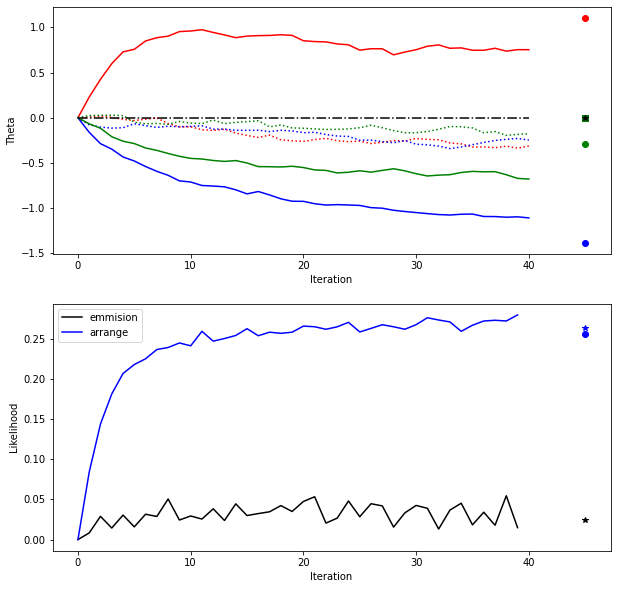

In [4]:

plt.figure(figsize=(10,10))
theta,i,thetaT=simulate_potts_gauss_duo(theta_w=0,sigma2 = 0.1,fit_theta_w=False,numiter=40)

The upper panel showt the parameter estimates (logpi,theta_w) for the 40 interactions. The dots show the true parameter values. The lower panel shows the expected likelihood, split up into emission likelihood and arrangement likelihood. 
The stars show the liklihood of the True model, the circle that of the independent model. 

### Example 1: Data is dependent - but fitting model is indepdent
Now we add a coupling term between the two nodes - clearly node 2 starts following the assignment of node 1. 
The model assumes independence of the nodes and therefore thinks that the $\pi_{2,k$ parameters are not equal to 0.25.  

U2    0.0  1.0   2.0   3.0
U1                        
0.0  39.0  9.0   6.0   5.0
1.0   NaN  1.0   NaN   NaN
2.0   2.0  3.0  16.0   1.0
3.0   3.0  1.0   2.0  12.0
U1
0.0    0.59
1.0    0.01
2.0    0.22
3.0    0.18
dtype: float64
U2
0.0    0.44
1.0    0.14
2.0    0.24
3.0    0.18
dtype: float64


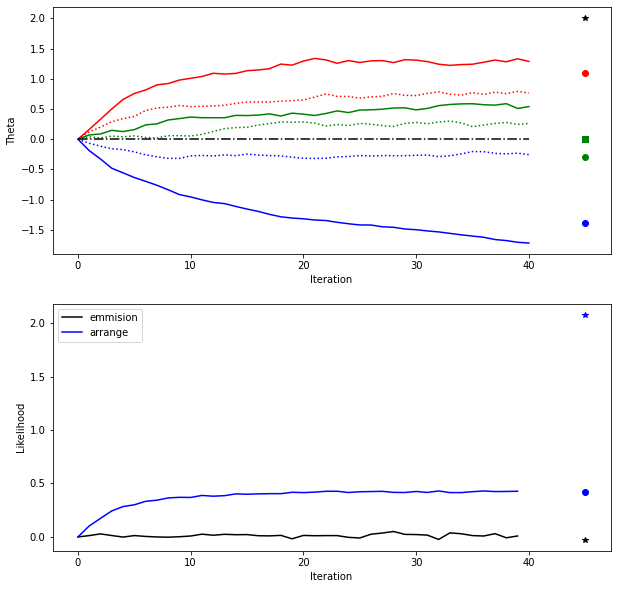

In [5]:
plt.figure(figsize=(10,10))
theta,i,thetaT=simulate_potts_gauss_duo(theta_w=2,sigma2 = 0.1,fit_theta_w=False,numiter=40)

The estimates of $\pi_2$ are biased and the arrangement likelihood is much below the true model. 

### Example 3: Dependent data - dependent model
Now we attempt to fit also the coupling term between the two nodes. 

U2    0.0  1.0   2.0   3.0
U1                        
0.0  39.0  3.0   6.0  10.0
1.0   NaN  3.0   1.0   NaN
2.0   2.0  3.0  19.0   2.0
3.0   1.0  NaN   3.0   8.0
U1
0.0    0.58
1.0    0.04
2.0    0.26
3.0    0.12
dtype: float64
U2
0.0    0.42
1.0    0.09
2.0    0.29
3.0    0.20
dtype: float64


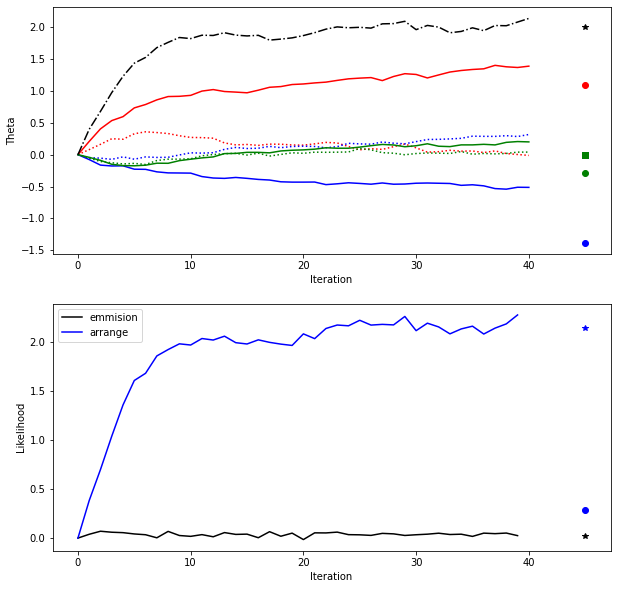

In [6]:
plt.figure(figsize=(10,10))
theta,i,thetaT=simulate_potts_gauss_duo(theta_w=2,sigma2 = 0.1,fit_theta_w=True,numiter=40)

The $\theta_w$ estimates starts increasing, removing the bias on the $pi_2$ parameters and achieving the true arrangement likelihood. 

## Simultaenous fitting of arrangement and emission model
- do estep and mstep on spatially indepepdent model 
- use as starting values for the spatial arrangement model.... 
- Problem: flipping of parcel assignment makes interpretation a bit harder .  

## Evaluating models without knowing the partition function
In the above example, we could plot the expected complete log-liklihood as a lower bound to the marginal likelihood of the model. 
The problem is that, for the arrangement model, we don't have the partition function in general. So we can use new set of data to evaluate performance. 
The key question is how we make prediction for this data: 
$\theta_A$: Learned from a set of subjects including or excluding the subject
$\theta_E$ means: Learned from a set of subjects including or excluding the subject 
$\theta_E$ dispersion: Could be optimized / integrated out for each to-be-evluated subject. 
$\langle \mathbf{U} \rangle_q$: 

* Could be unknown (sampling from arrangement negative phase),
* Could be known from independent data or from the test data (expectation)
* Could be complete or partially known (and then inferred for the missing value). 